# 1D problem

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from scipy.stats import rankdata

import tensorflow_probability as tfp
tfd = tfp.distributions


In [4]:
tf.__version__

'2.0.0'

In [5]:
sns.set_style('darkgrid')

In [121]:
def create_data(n, sigma):
    x = np.linspace(0, 1, n)
    y_true = np.sin(x) + 0.5*np.sin(10*x)
    y = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, sigma, x.shape)
    return x, y, y_true


def rankz(obs,ensemble,mask):
    ''' Parameters
    ----------
    obs : array of observations 
    ensemble : array of ensemble, with the first dimension being the 
        ensemble member and the remaining dimensions being identical to obs
    mask : boolean mask of shape of obs, with zero/false being where grid cells are masked.  
    Returns
    -------
    histogram data for ensemble.shape[0] + 1 bins. 
    The first dimension of this array is the height of 
    each histogram bar, the second dimension is the histogram bins. 
         '''
    mask=np.bool_(mask)

    obs=obs[mask]
    ensemble=ensemble[:,mask]
    
    combined=np.vstack((obs[np.newaxis],ensemble))

    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    tie=np.unique(ties)

    for i in range(1,len(tie)):
        index=ranks[ties==tie[i]]
        #print('randomizing tied ranks for ' + str(len(index)) + ' instances where there is ' + str(tie[i]) + ' tie/s. ' + str(len(tie)-i-1) + ' more to go')
        ranks[ties==tie[i]]=[np.random.randint(index[j],index[j]+tie[i]+1,tie[i])[0] for j in range(len(index))]

    return np.histogram(ranks, bins=np.linspace(0.5, combined.shape[0]+0.5, combined.shape[0]+1))



def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

In [7]:
x_train, y_train, y_true = create_data(1000, 0.15)
x_valid, y_valid, y_true = create_data(1000, 0.15)

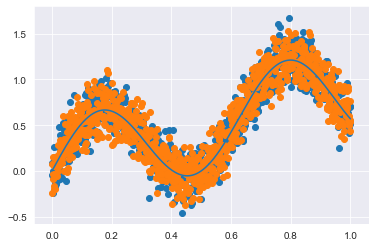

In [8]:
plt.scatter(x_train, y_train)
plt.scatter(x_valid, y_valid)
plt.plot(x_train, y_true);

## Parametric forecast

In [37]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


def crps_loss(y_true, y_pred):
    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]

    # To stop sigma from becoming negative we first have to
    # convert it the the variance and then take the square
    # root again.
    sigma = tf.nn.relu(sigma)

    # The following three variables are just for convenience
    loc = (y_true - mu) / tf.maximum(1e-7, sigma)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

    # Then we take the mean. The cost is now a scalar
    return crps

In [72]:
x_train, y_train, y_true = create_data(100000, 0.15)
x_valid, y_valid, y_true = create_data(1000, 0.15)

In [24]:
model = tf.keras.models.Sequential([
    Dense(128, input_shape=(1,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2)
])

In [73]:
model_prob = tf.keras.models.Sequential([
    Dense(128, input_shape=(1,), activation='elu'),
    Dense(128, activation='elu'),
    Dense(128, activation='elu'),
    Dense(2),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05*t[...,1:])))
])
model_prob.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


In [74]:
model.compile(tf.keras.optimizers.Adam(1e-5), crps_loss)

In [78]:
model.fit(x_train, y_train, batch_size=20, epochs=10, validation_data=(x_valid, y_valid))

In [79]:
model_prob.fit(x_train, y_train, batch_size=128, epochs=4, validation_data=(x_valid, y_valid))
yhat = model_prob(np.expand_dims(x_valid,axis=1))
s = yhat.stddev().numpy()
m = yhat.mean().numpy()

Train on 100000 samples, validate on 1000 samples
Epoch 1/4
100000/100000 [==============================] - 7s 72us/sample - loss: -0.0463 - val_loss: -0.3342
Epoch 2/4
100000/100000 [==============================] - 6s 55us/sample - loss: -0.3639 - val_loss: -0.4170
Epoch 3/4
100000/100000 [==============================] - 6s 55us/sample - loss: -0.4114 - val_loss: -0.3885
Epoch 4/4
100000/100000 [==============================] - 6s 62us/sample - loss: -0.4175 - val_loss: -0.4088

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



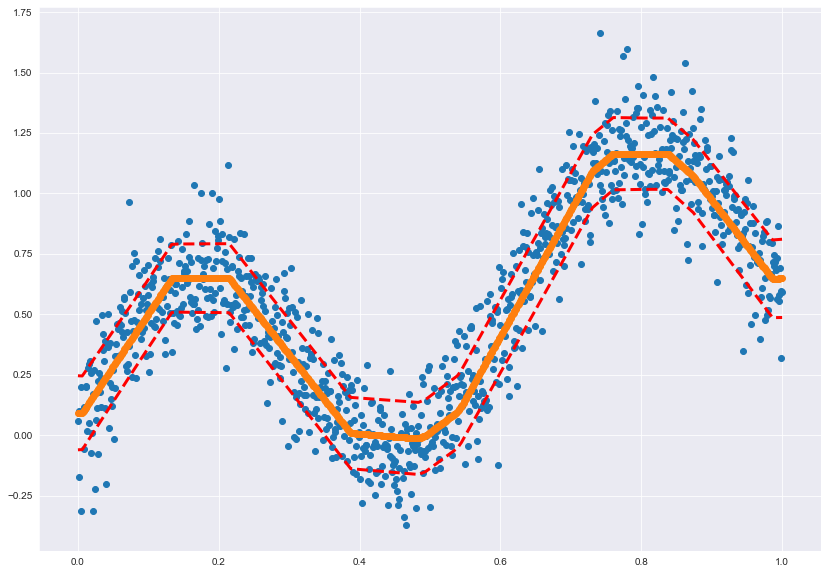

In [83]:
plt.figure(figsize=(14,10))
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid,m)
plt.plot(x_valid,m+s,'r--',linewidth=3)
plt.plot(x_valid,m-s,'r--',linewidth=3)
s = yhat.stddev()


In [104]:
loss_LL = crps_loss(y_valid,np.concatenate([m,s],axis=1)).numpy().mean()
print('CRPS Log Loss:', loss_LL )

CRPS Log Loss: 0.08962985


## Rank Histogram:

In [123]:
#sample from the distribution: 
eN= 60 
allEnse = np.zeros([eN,m.shape[0]])

for ss, mean_ in enumerate(m): 
    allEnse[:,ss]=  np.random.normal(mean_,s[ss],eN)


In [127]:
rr = ranker(y_valid,allEnse)

computing ranks
computing ties


(array([161., 113., 126.,  83.,  99., 103.,  80.,  85.,  71.,  79.]),
 array([ 1.,  7., 13., 19., 25., 31., 37., 43., 49., 55., 61.]),
 <a list of 10 Patch objects>)

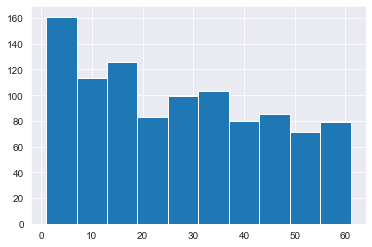

In [128]:
plt.hist(rr,)

In [120]:
allEnse.shape

(1000, 60)

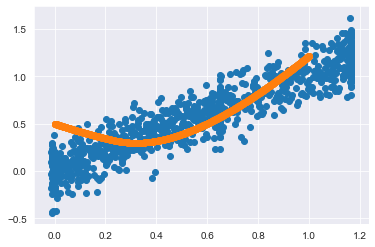

In [56]:
m = yhat.mean()
s = yhat.stddev()

plt.scatter(m, y_valid)
plt.scatter(x_valid, preds)

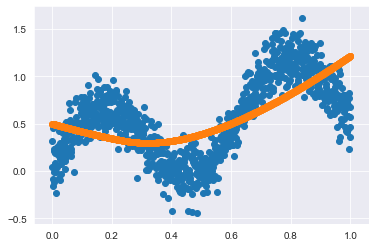

In [22]:
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid, preds)

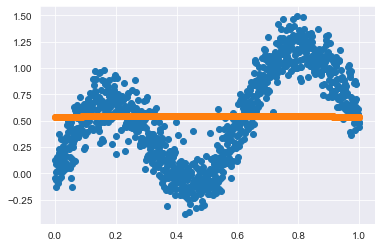

In [76]:
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid, preds[:, 0])

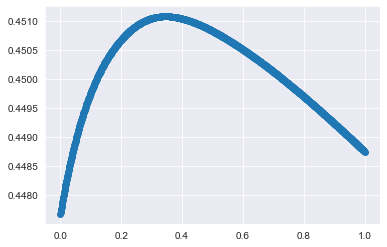

In [71]:
plt.scatter(x_valid, preds[:, 1])

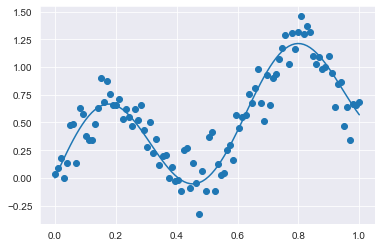

In [5]:
# Gaussian
y = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, 0.15, x.shape)
plt.scatter(x, y)
plt.plot(x, y_true);

In [ ]:
y_train, y_valid = 

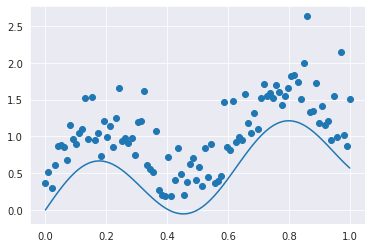

In [ ]:
# Skewed
y = np.sin(x) + 0.5*np.sin(10*x) + np.random.gamma(3, 0.15, x.shape)
plt.scatter(x, y)
plt.plot(x, y_true);

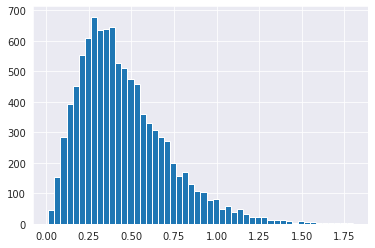

In [ ]:
plt.hist(np.random.gamma(3, 0.15, 10000), bins=50);

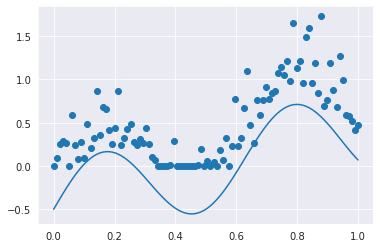

In [ ]:
# Truncated
y = -0.5 + np.sin(x) + 0.5*np.sin(10*x) + np.random.gamma(3, 0.15, x.shape)
y = np.maximum(y, 0)
plt.scatter(x, y)
plt.plot(x, y_true-0.5);

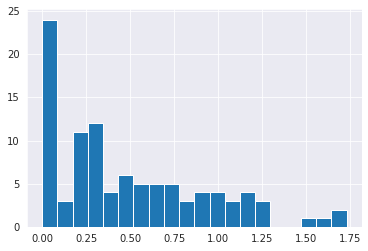

In [ ]:
plt.hist(y, bins=20);

In [ ]:
# Bimodal
y = np.sin(x) + 0.5*np.sin(10*x) + ???
plt.scatter(x, y)
plt.plot(x, y_true);

## 2D example

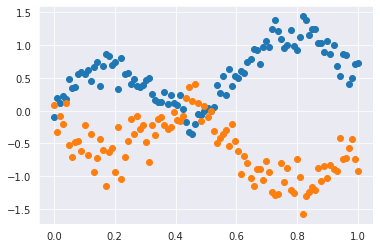

In [ ]:
# Gaussian
y1 = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, 0.15, x.shape)
y2 = -y1 + np.random.normal(0, 0.15, x.shape)
plt.scatter(x, y1)
plt.scatter(x, y2)

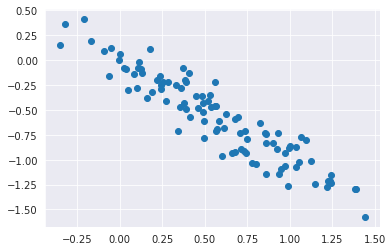

In [ ]:
plt.scatter(y1, y2)